<a href="https://colab.research.google.com/github/kristellu/mental_illness_pipeline/blob/master/mental_illness_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Application of Natural Language Processing and Deep Learning Models for the Detection of Mental Health Disorders in Social Networks.**

 *Kristell Urueta and José Márquez are with the Systems Engineering and Computer Science Department, Universidad del Norte, Barranquilla, CO 018000 Colombia, (e-mail:kristellu@uninorte.edu.co, jmarquez@uninorte.edu.co).*

**Abstract**— This study shows the use of Artificial Intelligence (AI) techniques and advanced trained models to analyze emotions expressed in social network texts, focusing on their relationship with mental health disorders. Using the NLTK library and algorithms such as VADER in Python, a natural language processing model is implemented to classify messages into specific emotional categories: positive, negative and neutral. Messages classified as negative are filtered for a more detailed study of the concerns and adverse emotions expressed. Additionally, the Latent Dirichlet Allocation (LDA) model is employed for thematic segmentation of the data, identifying patterns and themes prevalent in negative messages. This combined methodology provides a comprehensive understanding of the emotions and concerns manifested in the texts, facilitating the inference of possible underlying mental states. To enrich the analysis, it integrates with OpenAI's GPT-3.5 and GPT-4.0 API, offering advanced and contextualized interpretations of the connection between identified themes and associated emotions. This approach presents itself as a valuable tool for psychology and psychiatry, particularly for monitoring and analyzing mental health indicators in digital communications.

***Index Terms***— Bidirectional Encoder Representations from Transformers (BERT), Latent Dirichlet Allocation (LDA), TF-IDF, Natural Language Processing (NLP), Topic Modeling, VADER Sentiment Analysis.

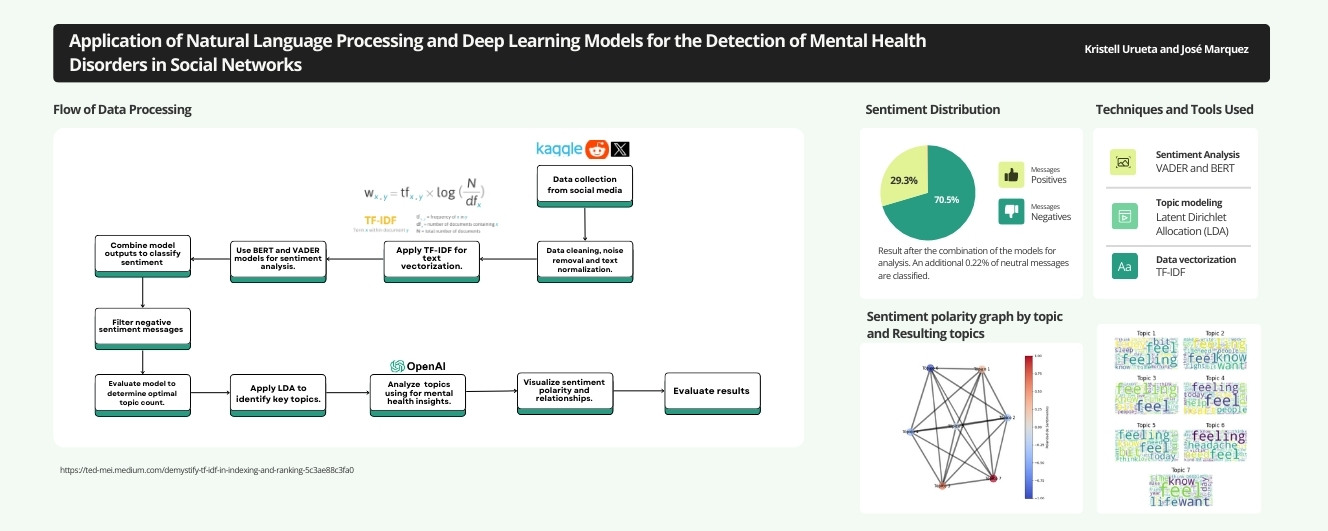

# Dependencies

In [1]:
!pip install pandas nltk scikit-learn matplotlib seaborn xlrd openpyxl
!pip install cohere tiktoken gensim openai
!pip install transformers
!pip install torch
!pip install vaderSentiment
!pip install openai

# Loading the dataset

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/Maestria2024/TESIS_AVANCES/paper

/content/drive/MyDrive/Maestria2024/TESIS_AVANCES/paper


# Sentiment analysis of the received dataset

We clean the received dataset and use NLP for the segmentation of the received data and return the file categorized by emotions.

This script performs the following tasks:


*   Cleans and prepares the tweets for analysis.

*   Utilizes both BERT (through Hugging Face's pipeline) and VADER for sentiment analysis.

* Combines the outputs from both models to determine the final sentiment label, focusing on a neutral classification when both models agree on neutrality, adjusted for VADER's threshold.


In [4]:
import pandas as pd
import torch
from transformers import DistilBertTokenizer, pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
import nltk
from nltk import download
from nltk.corpus import stopwords

nltk.download('punkt', force=True)
nltk.download('punkt_tab')

# Download stopwords from NLTK
download('stopwords')
download('punkt')
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Clean and prepare the message
def clean_message(text):
    if text is None or text != text:
        return ''
    text = str(text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Eliminar stopwords
    return text

In [6]:
def truncate_message(text, tokenizer):
    # Encode the text, truncate it to the maximum length the model can handle, and return the truncated string
    # 'max_length' is set to 512 because it is the maximum length that models like BERT can handle
    encoded = tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True)
    return tokenizer.decode(encoded)

In [7]:

# ================================
# 1. Información y características del dataset
# ================================
# Se asume que el archivo 'dataset_eng.xlsx' contiene:
#   - Una columna sin encabezado que corresponde a mensajes en inglés.
#   - Número total de muestras y posibles limitaciones en la recopilación (p.ej., textos breves, ruido, etc.).
# En este ejemplo se carga únicamente la primera columna.
df = pd.read_excel("dataset_eng.xlsx", usecols=[0], header=None)
df.columns = ['message']

print(f"Total number of elements in the initial dataset: {len(df)}")

# Mostrar características del dataset para garantizar la reproducibilidad
print("Características del dataset:")
print("- Idioma: Inglés")
print(f"- Número total de muestras: {len(df)}")
print("- Columnas:", df.columns.tolist())
print("Información del DataFrame:")
print(df.info())
print("\nEjemplo de datos:")
display(df.head())

# Apply the cleaning function to the 'message' column
df['clear_message'] = df['message'].apply(clean_message)

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load tokenizer and model specifically fine-tuned for sentiment analysis
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=device,
    tokenizer=tokenizer,
    truncation=True
)

# Perform sentiment analysis with BERT
df['bert_sentiments'] = df['clear_message'].apply(lambda x: sentiment_pipeline(x)[0])

# Instantiate and use VADER
analyzer = SentimentIntensityAnalyzer()
df['vader_sentiments'] = df['clear_message'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Normalize VADER scores to match BERT score scale (0 to 1)
df['vader_normalized'] = (df['vader_sentiments'] + 1) / 2

# Get BERT scores normalized (already between 0 and 1)
df['bert_scores'] = df['bert_sentiments'].apply(lambda x: x['score'] if x['label'].lower() == 'positive' else -x['score'])
df['bert_normalized'] = (df['bert_scores'] + 1) / 2

# Combine scores with a weighted average
weight_bert = 0.7
weight_vader = 0.3
df['combined_score'] = df['bert_normalized'] * weight_bert + df['vader_normalized'] * weight_vader

print("\nPesos asignados a los modelos:")
print(f" - BERT: {weight_bert*100:.0f}%")
print(f" - VADER: {weight_vader*100:.0f}%")

# Determine final sentiment from combined scores
def combined_label(score):
    if score > 0.6:
        return 'positive'
    elif score < 0.4:
        return 'negative'
    else:
        return 'neutral'

df['final_sentiment'] = df['combined_score'].apply(combined_label)

Total number of elements in the initial dataset: 23731
Características del dataset:
- Idioma: Inglés
- Número total de muestras: 23731
- Columnas: ['message']
Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23731 entries, 0 to 23730
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   message  23731 non-null  object
dtypes: object(1)
memory usage: 185.5+ KB
None

Ejemplo de datos:


,message
0,i didnt feel humiliated
1,i can go from feeling so hopeless to so damned...
2,im grabbing a minute to post i feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...
4,i am feeling grouchy


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Pesos asignados a los modelos:
 - BERT: 70%
 - VADER: 30%


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



#### **Sentiment Distribution Chart**
This chart seeks to show the number of initial messages classified in each sentiment category (positive, negative, neutral).

 A high proportion of negative messages may indicate a prevalence of concerns or negative emotional states in the data analyzed. This information can be crucial to identify worrying emotional patterns in the context studied.


,Sentiment,Quantity,Percentage
0,negative,16718,70.447937
1,positive,6960,29.328726
2,neutral,53,0.223337
0,Total,23731,100.000000


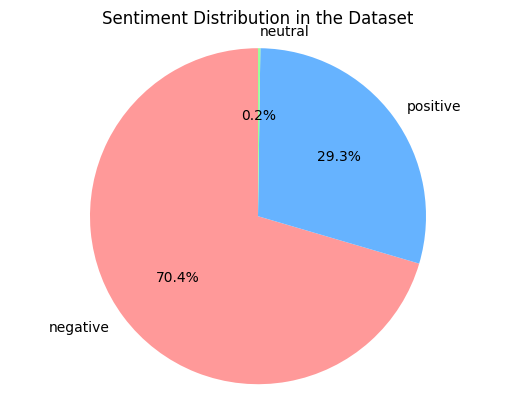

File result_categorized.xlsx saved!


In [9]:
# Create a summary table with quantity, percentage, and total
sentiment_summary = df['final_sentiment'].value_counts().reset_index()
sentiment_summary.columns = ['Sentiment', 'Quantity']
sentiment_summary['Percentage'] = 100 * sentiment_summary['Quantity'] / sentiment_summary['Quantity'].sum()
total_row = pd.DataFrame([['Total', sentiment_summary['Quantity'].sum(), 100.0]], columns=['Sentiment', 'Quantity', 'Percentage'])
sentiment_summary = pd.concat([sentiment_summary, total_row])


# Display the summary table
display(sentiment_summary)

# Visualization of the sentiment distribution
labels = df['final_sentiment'].value_counts().index
sizes = df['final_sentiment'].value_counts().values

# Calculate percentages
sizes = 100 * sizes / sizes.sum()

# Create pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Title of the chart
print("")
plt.title('Sentiment Distribution in the Dataset')

# Show the chart
plt.show()

# Save to Excel
file_name = 'result_categorized.xlsx'
df[['message', 'final_sentiment']].to_excel(file_name, index=False, engine='openpyxl')
print(f"File {file_name} saved!")

# Topic Modeling

Generating topics from a dataset, especially focusing on negative sentiments, can provide valuable insights into the underlying issues or concerns. The process typically involves the following steps

* Filter for Negative Sentiments: Extract only the negative sentiment messages.
* Vectorize the Text: Use TF-IDF vectorization.
* Apply LDA: Use LDA for topic modeling.


In [10]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
from collections import Counter
import gensim
from gensim.models import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import networkx as nx

df = pd.read_excel("result_categorized.xlsx")
display(df)

,message,final_sentiment
0,i didnt feel humiliated,positive
1,i can go from feeling so hopeless to so damned...,negative
2,im grabbing a minute to post i feel greedy wrong,negative
3,i am ever feeling nostalgic about the fireplac...,positive
4,i am feeling grouchy,negative
...,...,...
23726,is that snow,positive
23727,moulin rouge mad me cry once again,negative
23728,trying to shout but can t find people on the list,negative
23729,ughh can t find my red sox hat got ta wear thi...,negative


In [11]:
# Filtrar mensajes con sentimiento negativo
negative_df = df[df['final_sentiment'] == 'negative'].copy()

# Descargar recursos necesarios de nltk
download('stopwords')
download('punkt')

# Tokenización y eliminación de stopwords
stop_words = set(stopwords.words('english'))
negative_df['processed_message'] = negative_df['message'].apply(
    lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words])
)
# Vectorización de texto usando TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(negative_df['processed_message'])

# Función para mostrar tópicos
def display_topics(model, feature_names, no_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topics.append(top_words)
        print(f"Tópico {topic_idx + 1}:")
        print(top_words)
    return topics

# Función para calcular la coherencia de los tópicos
def compute_coherence_values(tfidf, texts, dictionary, k):
    lda_model = LatentDirichletAllocation(n_components=k, random_state=42)
    lda_model.fit(tfidf)
    topics = lda_model.components_
    coherence_model_lda = CoherenceModel(
        topics=[[dictionary[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in topics],
        texts=texts, dictionary=dictionary, coherence='c_v'
    )
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Convertir mensajes en formato adecuado para el cálculo de coherencia
texts = [text.split() for text in negative_df['processed_message']]
id2word = gensim.corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Calcular puntajes de coherencia para diferentes números de tópicos
coherence_scores = []
for num_topics in range(2, 11):
    coherence_score = compute_coherence_values(tfidf, texts, id2word, num_topics)
    coherence_scores.append((num_topics, coherence_score))
    print(f"Número de Tópicos: {num_topics}, Coherencia: {coherence_score}")

# Seleccionar el número óptimo de tópicos
optimal_num_topics = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Número óptimo de tópicos: {optimal_num_topics}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Número de Tópicos: 2, Coherencia: 0.4554582891424778
Número de Tópicos: 3, Coherencia: 0.4383219708317945
Número de Tópicos: 4, Coherencia: 0.4531381416155967
Número de Tópicos: 5, Coherencia: 0.42856569125551075
Número de Tópicos: 6, Coherencia: 0.4571446681487054
Número de Tópicos: 7, Coherencia: 0.4575637043924962
Número de Tópicos: 8, Coherencia: 0.4567806046545967
Número de Tópicos: 9, Coherencia: 0.4317573637994644
Número de Tópicos: 10, Coherencia: 0.4418814250008859
Número óptimo de tópicos: 7


In [12]:
lda_model = LatentDirichletAllocation(n_components=optimal_num_topics, random_state=42)
lda_model.fit(tfidf)

# Crear DataFrame para los temas
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Formatear los temas y palabras clave
topics_data = []
for idx, topic in enumerate(lda_model.components_):
    topic_words = [tfidf_feature_names[i] for i in topic.argsort()[:-len(topic) - 1:-1]]
    topic_str = ' '.join(topic_words)
    topics_data.append({"Topic": f"Topic {idx + 1}", "Words": topic_str})

topics_df = pd.DataFrame(topics_data)
print("\nTemas extraídos:")
display(topics_df)

# Guardar temas en Excel
topics_df.to_excel("result_topics_negative.xlsx", index=False)

print("Los tópicos han sido guardados en 'result_topics_negative.xlsx'.")


Temas extraídos:


,Topic,Words
0,Topic 1,feel feeling im like little punished today dis...
1,Topic 2,feel feeling like im things awkward regretful ...
2,Topic 3,feel feeling im like really dont sad ive know ...
3,Topic 4,depression feel feeling cold anxiety like thee...
4,Topic 5,feel feeling im like agitated stressed little ...
5,Topic 6,http feel href depression com feeling heartbro...
6,Topic 7,feel like wa want life know time day people re...


Los tópicos han sido guardados en 'result_topics_negative.xlsx'.


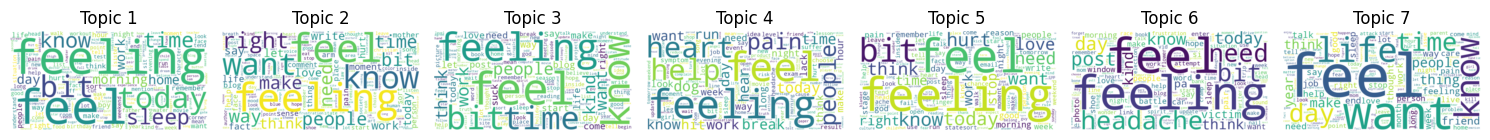

In [13]:
# Generar nubes de palabras para cada tópico
fig, axes = plt.subplots(1, optimal_num_topics, figsize=(15, 5), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    topic_words = topics_data[i]['Words']
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(topic_words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Topic {i + 1}")
plt.tight_layout()
plt.show()

In [14]:
# results_df = pd.DataFrame(columns=['Topic', 'Query'] + models)

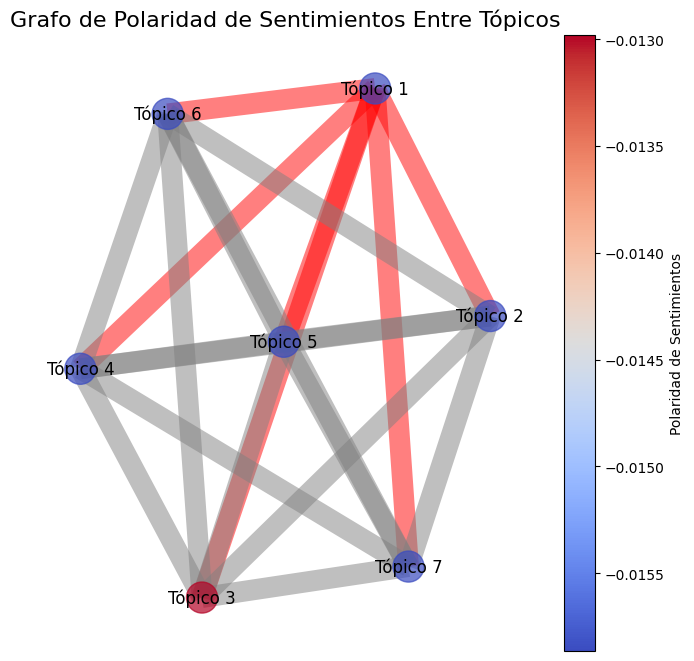

In [23]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ================================
# Grafo de Polaridad de Sentimientos Entre Tópicos
# ================================

# Suponemos que 'topics_df' es un DataFrame que contiene una columna 'Words'
# con las palabras clave (ordenadas por importancia) de cada tópico.

# Análisis de Sentimientos con VADER
analyzer = SentimentIntensityAnalyzer()

# Crear un grafo donde cada nodo es un tópico y los enlaces representan la similitud en polaridad
G = nx.Graph()

# Añadir nodos al grafo (cada nodo representa un tópico) y calcular la polaridad promedio
for i, topic in enumerate(topics_df['Words']):
    # Calcular la polaridad promedio de las palabras dentro del tópico
    avg_sentiment = np.mean([analyzer.polarity_scores(word)['compound'] for word in topic.split()])
    G.add_node(i, sentiment=avg_sentiment, label=f"Tópico {i + 1}")

# Añadir enlaces entre tópicos basados en la similitud de polaridad
for i in range(len(topics_df)):
    for j in range(i + 1, len(topics_df)):
        sentiment_i = G.nodes[i]['sentiment']
        sentiment_j = G.nodes[j]['sentiment']
        # La similitud se define como la inversa de la diferencia absoluta de las polaridades
        similarity = 1 - abs(sentiment_i - sentiment_j)
        G.add_edge(i, j, weight=similarity)

# Calcular la posición de los nodos usando spring_layout
pos = nx.spring_layout(G, seed=42)
# Extraer la polaridad de cada nodo para asignar el color
node_colors = [G.nodes[node]['sentiment'] for node in G]

# Crear la figura y los ejes (para poder asociar la barra de color al eje)
fig, ax = plt.subplots(figsize=(8, 8))

# Dibujar los nodos con un mapeo de colores según la polaridad
nodes = nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    cmap=plt.cm.coolwarm,
    node_size=500,
    alpha=0.7,
    ax=ax
)

# Inicializar un diccionario para almacenar, para cada nodo, la arista incidente con mayor peso
best_edge_for_node = {}
for node in G.nodes():
    incident_edges = []
    for neighbor in G.neighbors(node):
        # Se asegura de obtener la arista en una única dirección
        if G.has_edge(node, neighbor):
            incident_edges.append((node, neighbor))
        elif G.has_edge(neighbor, node):
            incident_edges.append((neighbor, node))
    if incident_edges:
        best_edge = max(incident_edges, key=lambda edge: G[edge[0]][edge[1]]['weight'])
        best_edge_for_node[node] = best_edge

# Crear el conjunto de aristas a resaltar (sin duplicados)
highlight_edges = set(best_edge_for_node.values())

edge_colors = []
edge_widths = []

for u, v in G.edges():
    if (u, v) in highlight_edges or (v, u) in highlight_edges:
        edge_colors.append('red')
    else:
        edge_colors.append('gray')
    edge_widths.append(G[u][v]['weight'] * 15)

# Dibujar las aristas
nx.draw_networkx_edges(
    G, pos,
    edge_color=edge_colors,
    width=edge_widths,
    alpha=0.5,
    ax=ax
)

# Dibujar las etiquetas de los nodos
nx.draw_networkx_labels(
    G, pos,
    labels={node: G.nodes[node]['label'] for node in G},
    font_size=12,
    font_color='black',
    ax=ax
)

# Configurar el título y quitar ejes
ax.set_title("Grafo de Polaridad de Sentimientos Entre Tópicos", fontsize=16)
ax.axis('off')

# Crear la barra de color (colorbar) usando los mismos parámetros del mapeo de colores
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="Polaridad de Sentimientos")

plt.show()


Nodos Representan Tópicos: Cada nodo en el grafo representa un tópico identificado mediante LDA. La polaridad promedio de las palabras en cada tópico determina el color del nodo.

Enlaces Basados en Similitud de Polaridad: Los enlaces entre los nodos representan la similitud de polaridad entre los tópicos. La similitud se calcula como la inversa de la diferencia absoluta de las polaridades promedio de los tópicos. Cuanto más similar sea la polaridad, más fuerte será el enlace entre los tópicos.


# Analysis and mental diagnosis of topical issues

Already having the information filtered and consolidated by topics, we proceed to make the diagnosis of possible mental illnesses detected in each one of them.


In [16]:
!pip install openai==0.28


In [19]:
import os
import re
import pandas as pd
import openai
from google.colab import auth
from getpass import getpass

# Prompt the user to input the API key securely
openai.api_key = getpass('Enter your OpenAI API key: ')

Enter your OpenAI API key: ··········


In [22]:
# Modelos a comparar
models = ["gpt-3.5-turbo-0125", "gpt-4"]

# Función para seleccionar las palabras más representativas de un tópico
def get_representative_words(topic_words, top_n=5):
    # Seleccionar las top_n palabras más importantes (se asume que ya están ordenadas por importancia)
    return " ".join(topic_words[:top_n])

# Inicializar el DataFrame para resultados
results_df = pd.DataFrame(columns=['Topic', 'Query'] + models)

# Iterar sobre cada tema en topics_df
for idx, row in topics_df.iterrows():
    topic_words = row["Words"].split()  # Palabras ya ordenadas por importancia
    query = get_representative_words(topic_words, top_n=5)
    result_row = {'Topic': row['Topic'], 'Query': query}

    # Obtener respuestas de cada modelo
    for model in models:
        try:
            response = openai.ChatCompletion.create(
                model=model,
                messages=[
                    {"role": "system", "content": "Diagnosis of psychological conditions or mental illnesses based on a set of given topical words. Provide a general diagnosis suitable for a report, without segmenting by context."},
                    {"role": "user", "content": query}
                ],
                temperature=0  # Temperatura en 0 para resultados consistentes
            )
            result_row[model] = response['choices'][0]['message']['content'].strip()
        except Exception as e:
            print(f"An error occurred with model {model} for topic {idx}: {e}")
            result_row[model] = 'Error occurred during API call'

    # Agregar la fila al DataFrame de resultados
    results_df = pd.concat([results_df, pd.DataFrame([result_row])], ignore_index=True)

# ================================
# 4. Reorganización y visualización tabular de los resultados comparativos
# ================================
# Configurar pandas para mostrar el contenido completo de las celdas
pd.set_option('display.max_colwidth', None)

# Función para comparar las respuestas (por ejemplo, en base a la longitud)
def compare_responses(row):
    resp_35 = row["gpt-3.5-turbo-0125"]
    resp_4 = row["gpt-4"]
    len_35 = len(resp_35.split())
    len_4 = len(resp_4.split())
    if len_4 > len_35:
         return "GPT-4 provides a more detailed response."
    elif len_4 < len_35:
         return "GPT-3.5 provides a more detailed response."
    else:
         return "Both responses have similar detail."

results_df["Comparison"] = results_df.apply(compare_responses, axis=1)

# Reorganizar columnas en un formato tabular: Topic, Query, gpt-3.5, gpt-4, y la comparación
results_df = results_df[["Topic", "Query", "gpt-3.5-turbo-0125", "gpt-4", "Comparison"]]

print("\nTabla comparativa entre GPT-3.5 y GPT-4:")
display(results_df)

# Guardar los resultados en un archivo CSV
results_df.to_csv("result_topic_analysis.csv", index=False)
print("Responses have been saved in result_topic_analysis.csv")


Tabla comparativa entre GPT-3.5 y GPT-4:


,Topic,Query,gpt-3.5-turbo-0125,gpt-4,Comparison
0,Topic 1,feel feeling im like little,Generalized Anxiety Disorder,"Based on the given words, it's not possible to provide a specific diagnosis as they are quite general and can be associated with a wide range of emotions and mental states. However, if the individual is expressing concern about their feelings, it may be beneficial to explore potential issues related to mood disorders, anxiety, or self-esteem. It's recommended that they consult with a mental health professional for a comprehensive evaluation.",GPT-4 provides a more detailed response.
1,Topic 2,feel feeling like im things,Generalized Anxiety Disorder,"Based on the provided words, it's difficult to provide a specific diagnosis. However, the words suggest a focus on emotions and self-perception. This could potentially indicate a range of conditions such as depression, anxiety, or mood disorders. Further information would be needed for a more accurate diagnosis.",GPT-4 provides a more detailed response.
2,Topic 3,feel feeling im like really,Generalized Anxiety Disorder,"Based on the given words, it's not possible to provide a specific diagnosis as these words are quite general and can be associated with a wide range of emotions and mental states. They could indicate a heightened sense of self-awareness or introspection, but without more specific information, it's not possible to diagnose a psychological condition or mental illness.",GPT-4 provides a more detailed response.
3,Topic 4,depression feel feeling cold anxiety,Generalized Anxiety Disorder,"The individual may be suffering from a combination of Major Depressive Disorder and Generalized Anxiety Disorder. The feelings of depression and anxiety, coupled with physical sensations such as feeling cold, suggest a significant level of psychological distress. Further evaluation and treatment are recommended.",GPT-4 provides a more detailed response.
4,Topic 5,feel feeling im like agitated,Generalized Anxiety Disorder,"The given topical words suggest symptoms of Generalized Anxiety Disorder (GAD). The individual appears to be experiencing persistent feelings of agitation. However, a comprehensive assessment is necessary to confirm this diagnosis.",GPT-4 provides a more detailed response.
5,Topic 6,http feel href depression com,"Based on the provided text ""http feel href depression com,"" it is not possible to make a diagnosis of a psychological condition or mental illness. It appears to be a random collection of words and does not provide enough information to determine any specific diagnosis. It is important to consult with a mental health professional for a proper evaluation and diagnosis if you are experiencing symptoms of depression or any other mental health concerns.","The given topical words suggest a focus on Depression, a common mental health disorder characterized by persistent feelings of sadness, loss of interest, and difficulty in performing daily activities.",GPT-3.5 provides a more detailed response.
6,Topic 7,feel like wa want life,Existential crisis.,"Based on the given topical words, the individual may be experiencing symptoms of depression. These symptoms can include feelings of hopelessness, lack of interest in life, and persistent sadness. It's important to note that a comprehensive assessment by a mental health professional is necessary for an accurate diagnosis.",GPT-4 provides a more detailed response.


Responses have been saved in result_topic_analysis.csv
